<a href="https://colab.research.google.com/github/JinHuiXu1991/Jin_DATA606/blob/main/ipynb/DATA606_Part2_CollaborativeRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Product Recommender Systems
## Author: Jin Hui Xu

#Collaborative Filtering 

In [3]:
!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_product.zip?raw=true

!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_review.zip?raw=true

--2022-04-10 04:21:20--  https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_product.zip?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/cleaned_data/cleaned_amazon_product.zip [following]
--2022-04-10 04:21:20--  https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/cleaned_data/cleaned_amazon_product.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/cleaned_data/cleaned_amazon_product.zip [following]
--2022-04-10 04:21:20--  https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/cleaned_data/cleaned_amazon_product.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.

In [4]:
!pip install surprise

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as train_test_split2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from surprise import dump
import os
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import GridSearchCV
import gzip
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
review_df = pd.read_csv('/content/cleaned_amazon_review.zip?raw=true', compression='zip')

review_df.head()

,overall,reviewTime,reviewerID,asin,reviewText,summary,reviewTimeYear,reviewTimeMonth
0,5.0,2013-11-27,A3NHUQ33CFH3VM,1118461304,not one thing in this book seemed an obvious o...,clear on what leads to innovation,2013,11
1,5.0,2013-11-01,A3SK6VNBQDNBJE,1118461304,i have enjoyed dr alan gregerman s weekly blog...,becoming more innovative by opening yourself t...,2013,11
2,5.0,2013-10-10,A3SOFHUR27FO3K,1118461304,alan gregerman believes that innovation comes ...,the world from different perspectives,2013,10
3,5.0,2013-10-09,A1HOG1PYCAE157,1118461304,alan gregerman is a smart funny entertaining w...,strangers are your new best friends,2013,10
4,5.0,2013-09-07,A26JGAM6GZMM4V,1118461304,as i began to read this book i was again remin...,how and why it is imperative to engage learn f...,2013,9


In [7]:
#Remove all information except Reviewer ID, Product ID and rating
review_df['all_review_text'] = review_df['reviewText'] + review_df['summary']
review_df = review_df[['reviewerID', 'asin', 'overall', 'all_review_text']]

In [8]:
product_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')

product_df.head()

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title
0,"Appliances Refrigerators, Freezers & Ice Makers",NaN,tupperware freezer square round container set ...,tupperware,each 3 pc set includes two 7 8 cup 200 ml and ...,appliances,2008-11-19,NaN,7301113188,[],2008,11,Tupperware Freezer Square Round Container Set ...
1,"Appliances Refrigerators, Freezers & Ice Makers",2 x tupperware pure fresh unique covered cool ...,2 x tupperware pure amp fresh unique covered c...,tupperware,2 x tupperware pure fresh unique covered cool ...,appliances,2016-06-05,3.62,7861850250,['https://images-na.ssl-images-amazon.com/imag...,2016,6,2 X Tupperware Pure &amp; Fresh Unique Covered...
2,Appliances Parts & Accessories,NaN,the cigar moments of pleasure,the cigar book,NaN,amazon home,NaN,150.26,8792559360,['https://images-na.ssl-images-amazon.com/imag...,0,0,The Cigar - Moments of Pleasure
3,Appliances Parts & Accessories,multi purpost descaler especially suited to wa...,caraselle 2x 50g appliance descalene,caraselle,NaN,tools home improvement,2014-12-17,NaN,9792954481,['https://images-na.ssl-images-amazon.com/imag...,2014,12,Caraselle 2X 50G Appliance Descalene
4,Appliances Parts & Accessories Range Parts & A...,full gauge and size beveled edge furnished wit...,eaton wiring 39ch sp l arrow hart 1 gang chrom...,eaton wiring,returns will not be honored on this closeout i...,tools home improvement,2007-01-16,3.43,B00002N5EL,[],2007,1,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...


In [9]:
#Remove all information except Product ID and title
product_df = product_df[['asin']]

In [10]:
merged_df = review_df.merge(product_df, on='asin', how='inner')
merged_df.head()

,reviewerID,asin,overall,all_review_text
0,A3SHVDMM83IHJ4,B00002N7IL,5.0,just what i needed for my electric range match...
1,A3TIWHNJXMSIU7,B00002N7IL,5.0,this particular type is perfect and easily ada...
2,AVP16JFIT6LPL,B00002N7IL,5.0,excellentfive stars
3,A2J2T9LX2HC947,B00002N7IL,5.0,yea babyfive stars
4,AJN26F4KMWD59,B00002N7IL,5.0,well made and works wellfive stars


In [11]:
# Tokenize, stem, and lemmatize the text
stop = stopwords.words('english')
def preprocess(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

porter = PorterStemmer()
def stem(input):
    return [porter.stem(word) for word in input]

lem = WordNetLemmatizer()
def lemma(input):
    return [lem.lemmatize(w) for w in input]

In [12]:
merged_df.isnull().sum()

reviewerID           0
asin                 0
overall              0
all_review_text    435
dtype: int64

In [13]:
merged_df = merged_df.fillna('')
merged_df.isnull().sum()

reviewerID         0
asin               0
overall            0
all_review_text    0
dtype: int64

In [14]:
merged_df['all_review_text'] = merged_df['all_review_text'].apply(preprocess)
merged_df['all_review_text'] = merged_df['all_review_text'].apply(stem)
merged_df['all_review_text'] = merged_df['all_review_text'].apply(lemma)

def token_to_sen(input):
    return ' '.join(input)
    
merged_df['all_review_text'] = merged_df['all_review_text'].apply(token_to_sen)

def sentiment_analysis(input):
  testimonial = TextBlob(input)
  return testimonial.polarity

merged_df['polarity'] = merged_df['all_review_text'].apply(sentiment_analysis)
del merged_df['all_review_text']

In [15]:
merged_df

,reviewerID,asin,overall,polarity
0,A3SHVDMM83IHJ4,B00002N7IL,5.0,0.800000
1,A3TIWHNJXMSIU7,B00002N7IL,5.0,0.498667
2,AVP16JFIT6LPL,B00002N7IL,5.0,0.000000
3,A2J2T9LX2HC947,B00002N7IL,5.0,0.000000
4,AJN26F4KMWD59,B00002N7IL,5.0,0.000000
...,...,...,...,...
601625,A24A9P4F2SLTK5,B01HJH2PY0,5.0,0.300000
601626,A2JCB4KHBWEELW,B01HJHHEA0,2.0,0.366667
601627,A1LDYYVTLPP2Z5,B01HJHHEA0,5.0,1.000000
601628,AP1M5O06IOYZ7,B01HJH92JQ,1.0,0.000000


In [16]:
def convert_range(input):
  OldRange = (1 - (-1))  
  NewRange = (5 - 1)  
  NewValue = (((input - (-1)) * NewRange) / OldRange) + 1
  return NewValue

merged_df["rate_by_polarity"] = merged_df['polarity'].apply(convert_range)

In [17]:
merged_df = merged_df.groupby("reviewerID").filter(lambda x: len(x) > 1)

In [18]:
merged_df.shape

(150090, 5)

In [19]:
#Assign X as the original ratings dataframe and y as the user_id column of ratings.
X = merged_df.copy()
y = merged_df['reviewerID']

#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=42)

In [20]:
#Function that computes the RMSE
def custom_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def baseline(reviewer_id, product_id):
    return 3.0

In [21]:
def score(cf_model):
    
    #Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(X_test['reviewerID'], X_test['asin'])
    
    #Predict the rating for every user-movie tuple
    y_pred = np.array([cf_model(reviewer, product) for (reviewer, product) in id_pairs])
    
    #Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test['overall'])
    
    #Return the final RMSE score
    return custom_rmse(y_true, y_pred)

In [22]:
score(baseline)

1.8185019009709702

## Memory Based
Ratings Matrix

In [24]:
r_matrix = X_train.pivot_table(values='overall', index='reviewerID', columns='asin')

r_matrix

asin,9792954481,B00002N7HY,B00002N7IL,B00004SQHD,B00004SQHH,B00004YWK2,B00004YWK7,B000056J8D,B00005OU6T,B00006IV17,...,B01HHFUD1G,B01HHFUDAC,B01HHFUDQG,B01HICGMWC,B01HIEZ5F0,B01HIF4LIQ,B01HIQV5DE,B01HJGWMTO,B01HJH0KLK,B01HJH92JQ
reviewerID,,,,,,,,,,,,,,,,,,,,,
A00302287A5VF8R6JTUD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0096681Y127OL1H8W3U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0140712R69E7ZY58CEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01704365WXWXHQIZMHJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02635363YZWI9MI13CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZP73D91QZWD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZZQBMKBD6ZKD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZZRNGKUZKVIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#User Based Collaborative Filter using Mean Ratings
def cf_user_mean(reviewer_id, product_id):
    
    #Check if product id exists in r_matrix
    if product_id in r_matrix:
        #Compute the mean of all the ratings given to the product
        mean_rating = r_matrix[product_id].mean()
    
    else:
        #Default to a rating of 3.0 in the absence of any information
        mean_rating = 3.0
    
    return mean_rating

In [34]:
#Compute RMSE for the Mean model
score(cf_user_mean)

1.1885126490638636

In [35]:
r_matrix2 = X_train.pivot_table(values='rate_by_polarity', index='reviewerID', columns='asin')

r_matrix2

asin,9792954481,B00002N7HY,B00002N7IL,B00004SQHD,B00004SQHH,B00004YWK2,B00004YWK7,B000056J8D,B00005OU6T,B00006IV17,...,B01HHFUD1G,B01HHFUDAC,B01HHFUDQG,B01HICGMWC,B01HIEZ5F0,B01HIF4LIQ,B01HIQV5DE,B01HJGWMTO,B01HJH0KLK,B01HJH92JQ
reviewerID,,,,,,,,,,,,,,,,,,,,,
A00302287A5VF8R6JTUD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0096681Y127OL1H8W3U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0140712R69E7ZY58CEW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01704365WXWXHQIZMHJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02635363YZWI9MI13CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZP73D91QZWD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZZQBMKBD6ZKD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZZRNGKUZKVIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#User Based Collaborative Filter using Mean Ratings
def cf_user_mean(reviewer_id, product_id):
    
    #Check if product id exists in r_matrix
    if product_id in r_matrix:
        #Compute the mean of all the ratings given to the product
        mean_rating = r_matrix2[product_id].mean()
    
    else:
        #Default to a rating of 3.0 in the absence of any information
        mean_rating = 3.0
    
    return mean_rating

#Compute RMSE for the Mean model
score(cf_user_mean)

1.4392047389225617

## Weighted Mean

In [25]:
r_matrix_dummy = r_matrix.copy().fillna(0)

In [26]:
r_matrix_dummy

asin,9792954481,B00002N7HY,B00002N7IL,B00004SQHD,B00004SQHH,B00004YWK2,B00004YWK7,B000056J8D,B00005OU6T,B00006IV17,...,B01HHFUD1G,B01HHFUDAC,B01HHFUDQG,B01HICGMWC,B01HIEZ5F0,B01HIF4LIQ,B01HIQV5DE,B01HJGWMTO,B01HJH0KLK,B01HJH92JQ
reviewerID,,,,,,,,,,,,,,,,,,,,,
A00302287A5VF8R6JTUD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0096681Y127OL1H8W3U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0140712R69E7ZY58CEW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01704365WXWXHQIZMHJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02635363YZWI9MI13CD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZP73D91QZWD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZQBMKBD6ZKD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZRNGKUZKVIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Compute the cosine similarity matrix using the dummy ratings matrix
cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy)

In [ ]:
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.index, columns=r_matrix.index)

cosine_sim

In [ ]:
#User Based Collaborative Filter using Weighted Mean Ratings
def cf_user_wmean(reviewer_id, product_id):
    
    #Check if movie_id exists in r_matrix
    if product_id in r_matrix:
        
        #Get the similarity scores for the user in question with every other user
        sim_scores = cosine_sim[reviewer_id]
        
        #Get the user ratings for the product in question
        m_ratings = r_matrix[product_id]
        
        #Extract the indices containing NaN in the m_ratings series
        idx = m_ratings[m_ratings.isnull()].index
        
        #Drop the NaN values from the m_ratings Series
        m_ratings = m_ratings.dropna()
        
        #Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        #Compute the final weighted mean
        if sim_scores.sum() == 0.0:
          wmean_rating = 3.0
        else:
          wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()
    
    else:
        #Default to a rating of 3.0 in the absence of any information
        wmean_rating = 3.0
    
    return wmean_rating

In [ ]:
score(cf_user_wmean)

## Model Based

### Review Rating

In [ ]:
merged_df2 = review_df.merge(product_df, on='asin', how='inner')
merged_df2 = merged_df2.groupby("reviewerID").filter(lambda x: len(x) > 2)
merged_df2.shape

(49758, 3)

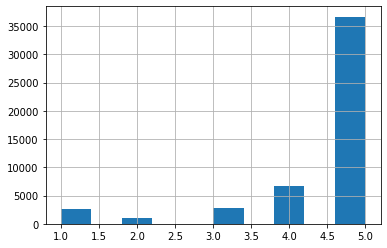

In [ ]:
merged_df2["overall"].hist()

In [ ]:
benchmark = []
reader = Reader()
# Iterate over all algorithms
data = Dataset.load_from_df(merged_df2, reader)
algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fca3df02490>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fca3df02490> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fca3df02590>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fca3df02590> 


Starting:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fca3df024d0>
Done:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fca3df024d0> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7fca3df020d0>
Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7fca3df020d0> 


Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fca3df02310>
Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fca3df02310> 


Starting:  <surprise.prediction_algorithms.knns.KNNBaseline object 

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.947327,7.219476,0.219273
SVD,0.961624,2.116916,0.092574
KNNBaseline,0.982159,5.743179,0.781147
BaselineOnly,0.983137,0.119876,0.046547
KNNBasic,1.033497,5.335949,0.775396
KNNWithZScore,1.053384,5.902286,0.726754
KNNWithMeans,1.054738,5.813654,0.725256
CoClustering,1.064421,2.025318,0.099677
SlopeOne,1.065400,1.846234,0.113678


In [ ]:
param_grid = {
    "n_epochs": [10, 20, 30, 40],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.02, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], refit=True, cv=5, n_jobs=5)
gs.fit(data)

# save the best parameters
training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.9214604398725019
BEST params: 	 {'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.02}


In [ ]:
# data = Dataset.load_from_df(merged_df2, reader)
# trainset, testset = train_test_split2(data, test_size=.2, random_state=42)

# # We'll use the famous SVD algorithm.
# algo = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

# cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=True)

# # Train the algorithm on the trainset, and predict ratings for the testset
# algo.fit(trainset)
# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)

In [ ]:
data = Dataset.load_from_df(merged_df2, reader)

# use the best parameters to train our SVD model
svd = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

# do some cross_validate for the dataset and see the rmse score
cross_validate(svd, data, measures=['rmse'], cv=10, verbose=True)

Evaluating RMSE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9246  0.9061  0.9138  0.9021  0.9073  0.8909  0.9092  0.9010  0.9440  0.8950  0.9094  0.0146  
Fit time          4.44    4.52    4.37    4.45    4.45    4.36    4.51    4.46    4.50    4.49    4.45    0.05    
Test time         0.03    0.04    0.05    0.31    0.03    0.04    0.03    0.03    0.03    0.03    0.06    0.08    


{'fit_time': (4.440197229385376,
  4.5239527225494385,
  4.369327068328857,
  4.445080280303955,
  4.453827857971191,
  4.357221603393555,
  4.510613679885864,
  4.456227779388428,
  4.498319864273071,
  4.486540794372559),
 'test_rmse': array([0.92456237, 0.90611315, 0.91379131, 0.90210467, 0.90727416,
        0.89091963, 0.90918029, 0.90100332, 0.94399503, 0.89498582]),
 'test_time': (0.032396554946899414,
  0.037935733795166016,
  0.046000003814697266,
  0.30960941314697266,
  0.03247809410095215,
  0.03804636001586914,
  0.032800912857055664,
  0.0344395637512207,
  0.032048940658569336,
  0.03260445594787598)}

The average RMSE score is 0.9112 which is the best among all other algorithms.

In [ ]:
# train our final SVD model
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
model_filename = "./cr_model.pickle"

# save trained model and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=svd)


In [ ]:
def load_model(model_filename):
    file_name = os.path.expanduser(model_filename)
    _, loaded_model = dump.load(file_name)
    return loaded_model

In [ ]:
from collections import defaultdict
def collaborative_SVD_recommender(predictions, product_df):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:10]

    for uid, user_ratings in top_n.items():
      result = [iid for (iid, _) in user_ratings]

    return result, product_df[product_df['asin'].isin(result)]['ori_title'].tolist()

In [ ]:
def get_rec_user(uid, input_df):
  input_id = uid
  data1 = [input_id]
  data2 = input_df['asin'].unique().tolist()

  df = pd.DataFrame(data1)
  df.columns =['reviewerID']

  df1 = pd.DataFrame(data2)
  df1.columns =['asin']
  # filter out reviewed products
  reviewed_product = input_df[input_df['reviewerID'] == input_id].asin.unique().tolist()
  df1 = df1[~df1['asin'].isin(reviewed_product)]

  # Now to perform cross join, we will create
  # a key column in both the DataFrames to
  # merge on that key.
  df['key'] = 1
  df1['key'] = 1

  # to obtain the cross join we will merge
  # on the key and drop it.
  result = pd.merge(df, df1, on ='key')

  result['overall']=0.0
  del result['key']
  return result


In [ ]:
model_filename = "./cr_model.pickle"
loaded_model = load_model(model_filename)

result_list = []
title_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')
for index, id in enumerate(merged_df2['reviewerID'].unique().tolist()):
    input_id = id
    result = get_rec_user(input_id, merged_df2)
    valid_Dataset = Dataset.load_from_df(result, reader)

    testset = valid_Dataset.df.values.tolist()
    predictions = loaded_model.test(testset)


    asin, title = collaborative_SVD_recommender(predictions, title_df)
    for i in range(0, 10):
      result_list.append((input_id, asin[i], title[i]))

    if index % 100 == 0:
      print('{} items done'.format(index))

0 items done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100 items done
200 items done
300 items done
400 items done
500 items done
600 items done
700 items done
800 items done
900 items done
1000 items done
1100 items done
1200 items done
1300 items done
1400 items done
1500 items done
1600 items done
1700 items done
1800 items done
1900 items done
2000 items done
2100 items done
2200 items done
2300 items done
2400 items done
2500 items done
2600 items done
2700 items done
2800 items done
2900 items done
3000 items done
3100 items done
3200 items done
3300 items done
3400 items done
3500 items done
3600 items done
3700 items done
3800 items done
3900 items done
4000 items done
4100 items done
4200 items done
4300 items done
4400 items done
4500 items done
4600 items done
4700 items done
4800 items done
4900 items done
5000 items done
5100 items done
5200 items done
5300 items done
5400 items done
5500 items done
5600 items done
5700 items done
5800 items done
5900 items done
6000 items done
6100 items done
6200 items done
6300 items done
6

In [ ]:
result_df = pd.DataFrame(result_list)
result_df.columns = ['reviewerID', 'asin', 'ori_title']

In [ ]:
result_df

,reviewerID,asin,ori_title
0,A3TIWHNJXMSIU7,B00009W3P6,Certified Appliance Accessories 3-Wire Closed-...
1,A3TIWHNJXMSIU7,B00009W3P8,Certified Appliance Accessories 3-Wire Open-Ey...
2,A3TIWHNJXMSIU7,B00009W3PL,Certified Appliance Accessories 3-Wire Closed-...
3,A3TIWHNJXMSIU7,B00009W3PA,Certified Appliance Accessories 3-Wire Closed-...
4,A3TIWHNJXMSIU7,B0002GTTRC,"GE GSWF Refrigerator Water Filter, 1-Pack"
...,...,...,...
132385,A1CY6CQC5HPQGL,B0002YTLZY,Broan 413001 ADA Capable Non-Ducted Under-Cabi...
132386,A1CY6CQC5HPQGL,B0002YVK2Q,Fluidmaster 9WM60P2 Washing Machine Connector ...
132387,A1CY6CQC5HPQGL,B0006OJ286,RPS #HW500 Extended Life Wick Filter
132388,A1CY6CQC5HPQGL,B0006OQCLG,BestAir ES12 Kenmore 14911 / Emerson HDC-12 Re...


In [ ]:
compression_opts = dict(method='zip',archive_name='cr_result.csv')  
result_df.to_csv('cr_result.zip', index=False, header = True, compression=compression_opts)

In [ ]:
model_df = pd.read_csv('/content/cr_result.zip', compression='zip')

In [ ]:
reviewer_input_id = 'A1CY6CQC5HPQGL'

In [ ]:
print('Collaborative Recommender Result for customer {}: '.format(reviewer_input_id))

for i, product in enumerate(model_df[model_df['reviewerID'] == reviewer_input_id].values.tolist()):
  print('{}. {}, {}'.format(i+1, product[1], product[2]))

Collaborative Recommender Result for customer A1CY6CQC5HPQGL: 
1. B000056J8D, Protec DynaFilter Humidifier Cartridge, Air Cleaning, 3 ct.
2. B00009W3I4, HEARTLAND 21000 Energy Saving Dryer Vent Closure
3. B00009W3P6, Certified Appliance Accessories 3-Wire Closed-Eyelet 30-Amp Dryer Cord, 4ft
4. B00009W3P8, Certified Appliance Accessories 3-Wire Open-Eyelet 30-Amp Dryer Cord, 5ft
5. B0002I20AS, BestAir DU3, Duracraft Replacement, Paper Wick Humidifier Filter, 7.9" x 3.5" x 7.6"
6. B0002YTLZY, Broan 413001 ADA Capable Non-Ducted Under-Cabinet Range Hood, 30-Inch, White
7. B0002YVK2Q, Fluidmaster 9WM60P2 Washing Machine Connector 2-Pack, Braided Stainless Steel - 3/4 Hose Fitting x 3/4 Hose Fitting, 60-Inch Length
8. B0006OJ286, RPS #HW500 Extended Life Wick Filter
9. B0006OQCLG, BestAir ES12 Kenmore 14911 / Emerson HDC-12 Replacement Wick Filter - 4 filters
10. B00074TBC2, Broan QS130SS  220 CFM Under Cabinet Hood, 30-Inches, Stainless Steel


### Review Text Sentiment

In [ ]:
review_df2 = pd.read_csv('/content/cleaned_amazon_review.zip?raw=true', compression='zip')

review_df2['all_review_text'] = review_df2['reviewText'] + review_df2['summary']

In [ ]:
#Remove all information except Reviewer ID, Product ID and text
review_df2 = review_df2[['reviewerID', 'asin', 'all_review_text']]

In [ ]:
review_df2.isnull().sum()

reviewerID           0
asin                 0
all_review_text    437
dtype: int64

In [ ]:
review_df2 = review_df2.fillna('')
review_df2.isnull().sum()

reviewerID         0
asin               0
all_review_text    0
dtype: int64

In [ ]:
merged_df3 = review_df2.merge(product_df, on='asin', how='inner')
merged_df3 = merged_df3.groupby("reviewerID").filter(lambda x: len(x) > 2)
merged_df3.shape

(49758, 3)

In [ ]:
merged_df3

,reviewerID,asin,all_review_text
1,A3TIWHNJXMSIU7,B00002N7IL,this particular type is perfect and easily ada...
2,AVP16JFIT6LPL,B00002N7IL,excellentfive stars
23,A22U6Z2M9TO90N,B00004SQHD,cheaper than locally cant go wrong five stars
30,A11QC8XY4UEWI7,B00004SQHD,used for my bosch ev car charger so it is not ...
63,A1ISAGPQ7AIBY1,B00004YWK2,worksworks
...,...,...,...
601565,ANTWC02YFFY2U,B01HFYY7ZW,does what it says and is accurate great little...
601584,A23ZRF0IE2E12G,B01HHBKZTA,cheap price and works a job not for the faint ...
601604,AKYJGJSMJMGRS,B01HJH0KLK,the original one lasted about 3 years then i r...
601617,A76BRLOWSD88F,B01HJHHQM6,perfect fit knob job


In [ ]:
# Tokenize, stem, and lemmatize the text
stop = stopwords.words('english')
def preprocess(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

porter = PorterStemmer()
def stem(input):
    return [porter.stem(word) for word in input]

lem = WordNetLemmatizer()
def lemma(input):
    return [lem.lemmatize(w) for w in input]

In [ ]:
merged_df3['all_review_text'] = merged_df3['all_review_text'].apply(preprocess)
merged_df3['all_review_text'] = merged_df3['all_review_text'].apply(stem)
merged_df3['all_review_text'] = merged_df3['all_review_text'].apply(lemma)

In [ ]:
def token_to_sen(input):
    return ' '.join(input)
    
merged_df3['all_review_text'] = merged_df3['all_review_text'].apply(token_to_sen)


In [ ]:
def sentiment_analysis(input):
  testimonial = TextBlob(input)
  return testimonial.polarity

In [ ]:
merged_df3['polarity'] = merged_df3['all_review_text'].apply(sentiment_analysis)

In [ ]:
del merged_df3['all_review_text']

In [ ]:
merged_df3

,reviewerID,asin,polarity
1,A3TIWHNJXMSIU7,B00002N7IL,0.498667
2,AVP16JFIT6LPL,B00002N7IL,0.000000
23,A22U6Z2M9TO90N,B00004SQHD,-0.250000
30,A11QC8XY4UEWI7,B00004SQHD,0.225000
63,A1ISAGPQ7AIBY1,B00004YWK2,0.000000
...,...,...,...
601565,ANTWC02YFFY2U,B01HFYY7ZW,0.800000
601584,A23ZRF0IE2E12G,B01HHBKZTA,0.072000
601604,AKYJGJSMJMGRS,B01HJH0KLK,-0.033333
601617,A76BRLOWSD88F,B01HJHHQM6,0.700000


In [ ]:
def convert_range(input):
  OldRange = (1 - (-1))  
  NewRange = (5 - 1)  
  NewValue = (((input - (-1)) * NewRange) / OldRange) + 1
  return NewValue

In [ ]:
merged_df3["rate_by_polarity"] = merged_df3['polarity'].apply(convert_range)

In [ ]:
del merged_df3['polarity']

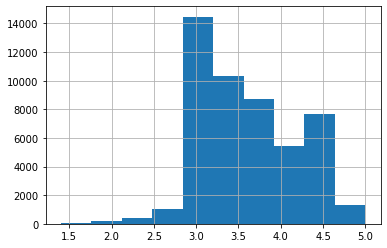

In [ ]:
merged_df3["rate_by_polarity"].hist()

In [ ]:
benchmark = []
reader = Reader()
# Iterate over all algorithms
data = Dataset.load_from_df(merged_df3, reader)
algorithms = [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fc9a80ce350>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fc9a80ce350> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fc9a80cea90>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fc9a80cea90> 


Starting:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fc9a80cea50>
Done:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fc9a80cea50> 


Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fc9b69be4d0>
Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fc9b69be4d0> 


Starting:  <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7fc9b69be510>
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.569643,7.226708,0.220447
SVD,0.577244,2.231829,0.069923
BaselineOnly,0.581132,0.117842,0.314418
KNNBaseline,0.593042,5.689323,0.780600
KNNBasic,0.616300,5.526747,0.790694
KNNWithMeans,0.636618,5.768568,0.747047
KNNWithZScore,0.641235,6.350805,0.765157
SlopeOne,0.660885,2.178553,0.114090
CoClustering,0.758778,2.040384,0.048873


In [ ]:
param_grid = {
    "n_epochs": [10, 20, 30, 40],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.02, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], refit=True, cv=5, n_jobs=5)
gs.fit(data)

# save the best parameters
training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.5635242182050272
BEST params: 	 {'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


In [ ]:
data = Dataset.load_from_df(merged_df3, reader)

# use the best parameters to train our SVD model
svd = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

# do some cross_validate for the dataset and see the rmse score
cross_validate(svd, data, measures=['rmse'], cv=10, verbose=True)

Evaluating RMSE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.5515  0.5576  0.5634  0.5721  0.5628  0.5600  0.5568  0.5612  0.5589  0.5603  0.5605  0.0051  
Fit time          4.74    4.67    4.73    4.65    4.72    4.74    4.65    4.64    4.67    4.63    4.68    0.04    
Test time         0.04    0.03    0.03    0.03    0.04    0.03    0.04    0.03    0.03    0.03    0.03    0.00    


{'fit_time': (4.7427098751068115,
  4.672486066818237,
  4.730555534362793,
  4.653571605682373,
  4.717276334762573,
  4.742250442504883,
  4.6455066204071045,
  4.642151594161987,
  4.6702563762664795,
  4.6251795291900635),
 'test_rmse': array([0.55152811, 0.5575592 , 0.56342747, 0.57213017, 0.56282677,
        0.55998171, 0.55684729, 0.56118733, 0.55886359, 0.56032995]),
 'test_time': (0.038465261459350586,
  0.03235316276550293,
  0.0326688289642334,
  0.03256559371948242,
  0.03686165809631348,
  0.03312110900878906,
  0.03634309768676758,
  0.034859418869018555,
  0.032077789306640625,
  0.033162832260131836)}

In [ ]:
# train our final SVD model
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
model_filename = "./cr_sentiment_model.pickle"

# save trained model and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=svd)

In [ ]:
model_filename = "./cr_sentiment_model.pickle"
loaded_model = load_model(model_filename)

result_list = []
title_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')
for index, id in enumerate(merged_df3['reviewerID'].unique().tolist()):
    input_id = id
    result = get_rec_user(input_id, merged_df3)
    valid_Dataset = Dataset.load_from_df(result, reader)

    testset = valid_Dataset.df.values.tolist()
    predictions = loaded_model.test(testset)


    asin, title = collaborative_SVD_recommender(predictions, title_df)
    for i in range(0, 10):
      result_list.append((input_id, asin[i], title[i]))

    if index % 100 == 0:
      print('{} items done'.format(index))

0 items done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100 items done
200 items done
300 items done
400 items done
500 items done
600 items done
700 items done
800 items done
900 items done
1000 items done
1100 items done
1200 items done
1300 items done
1400 items done
1500 items done
1600 items done
1700 items done
1800 items done
1900 items done
2000 items done
2100 items done
2200 items done
2300 items done
2400 items done
2500 items done
2600 items done
2700 items done
2800 items done
2900 items done
3000 items done
3100 items done
3200 items done
3300 items done
3400 items done
3500 items done
3600 items done
3700 items done
3800 items done
3900 items done
4000 items done
4100 items done
4200 items done
4300 items done
4400 items done
4500 items done
4600 items done
4700 items done
4800 items done
4900 items done
5000 items done
5100 items done
5200 items done
5300 items done
5400 items done
5500 items done
5600 items done
5700 items done
5800 items done
5900 items done
6000 items done
6100 items done
6200 items done
6300 items done
6

In [ ]:
result_df = pd.DataFrame(result_list)
result_df.columns = ['reviewerID', 'asin', 'ori_title']

compression_opts = dict(method='zip',archive_name='cr_sentiment_result.csv')  
result_df.to_csv('cr_sentiment_result.zip', index=False, header = True, compression=compression_opts)

In [ ]:
model_df = pd.read_csv('/content/cr_sentiment_result.zip', compression='zip')
reviewer_input_id = 'A1CY6CQC5HPQGL'

print('Collaborative Recommender Result for customer {}: '.format(reviewer_input_id))

for i, product in enumerate(model_df[model_df['reviewerID'] == reviewer_input_id].values.tolist()):
  print('{}. {}, {}'.format(i+1, product[1], product[2]))

Collaborative Recommender Result for customer A1CY6CQC5HPQGL: 
1. B00DNCHMDA,  Whirlpool Part Number 9760572
2. B001DPTZPM, Whirlpool Part Number 8181673: Gasket, Tub
3. B00PU15R34, Skuttle A00-0602-041 Water pan Model 90, 190 Humidifier
4. B00AUDABBU, LG Electronics 5210JA3004K 5/16-Inch Refrigerator Plastic Tubing
5. B0076OXZIC, Valterra A10-2620VP Fridge/Freezer Thermometer
6. B002YTOCP4, Replacement LG 5221ER1003A Washer Cold Water Valve
7. B00EMIL8Q6, Scotsman A39031-021 Ice Thickness Sensor
8. B00CCYW9HO, Whirlpool A341 Range Grill Cover Genuine Original Equipment Manufacturer (OEM) Part
9. B01FW8RF7A, Frigidaire 316136300 Range/Stove/Oven Fan Motor
10. B00EUZPIS0, #1 Premium Stove Counter Gap Cover - Set of 2 White - Stove Gap, Gap cap for stoves
